Let's see if we can load up some objects, integrate positions, then convert to RA,dec

In [1]:
import assist
import astropy.units as u
from astropy.coordinates import SkyCoord, ICRS,GCRS,EarthLocation


from astropy.time import Time
import rebound
from rubin_sim.moving_objects import Orbits
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
ephem = assist.Ephem("/Users/yoachim/rubin_sim_data/linux_p1550p2650.440", "/Users/yoachim/rubin_sim_data/sb441-n16.bsp")
time = Time(ephem.jd_ref, format="jd")
part = ephem.get_particle("Earth", 0)

In [3]:
part

<rebound.particle.Particle object at 0x1133f89d0, m=8.887692446707103e-10 x=-0.18427227843428148 y=0.8847811839446426 z=0.3838199903352723 vx=-0.017202246608380413 vy=-0.002904925902856414 vz=-0.0012594279121938968>

In [4]:
sc = SkyCoord(x=part.x*u.au, y=part.y*u.au, z=part.z*u.au, 
              representation_type='cartesian', obstime=time,
              frame=ICRS)

In [5]:
# Ah, so this is the RA,dec from the sun probably, that's why it keeps giving me ~1 AU dist
sc.transform_to(ICRS)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, AU)
    (101.76474291, 23.01041191, 0.98189195)>

In [6]:
sim = rebound.Simulation()
extras = assist.Extras(sim, ephem)

# If we are using orbital elements, need to put the sun in. Maybe the rest of the bodies too, I'm confused?
t_initial = 0 # Julian Days relative to jd_ref
sun_initial = ephem.get_particle("sun", t_initial)
sim.add(sun_initial)
        

In [7]:
rs_orbits = Orbits()
rs_orbits.read_orbits("/Users/yoachim/rubin_sim_data/orbits/l7_5k.txt")
#rs_orbits.read_orbits("/Users/yoachim/rubin_sim_data/orbits/granvik_5k.txt")

#rs_orbits.read_orbits("/Users/yoachim/rubin_sim_data/orbits/occ_rmax20_5k.txt")

N_objects = rs_orbits.orbits.shape[0]

In [8]:
rs_orbits.orbits

,a,e,inc,Omega,argPeri,meanAnomaly,H,j,type,inner,outer,epoch,objId,g,sed_filename,obj_id
0,44.236,0.182,28.109,51.440,244.298,288.191,8.42,43.13,classical,m,h,53157.0,0,0.15,TNO.dat,0
1,55.066,0.284,17.996,15.226,227.946,226.554,8.31,67.61,classical,o,0,53157.0,1,0.15,TNO.dat,1
2,44.710,0.108,5.966,85.787,80.317,330.394,7.98,40.66,classical,m,s,53157.0,2,0.15,TNO.dat,2
3,45.006,0.133,4.486,160.498,205.155,221.741,8.33,49.77,classical,m,s,53157.0,3,0.15,TNO.dat,3
4,55.244,0.540,19.464,147.566,30.841,18.338,6.93,31.40,resonant,5,2,53157.0,4,0.15,TNO.dat,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,44.028,0.188,15.816,319.203,89.221,96.687,7.02,46.44,classical,m,h,53157.0,4995,0.15,TNO.dat,4995
4996,43.356,0.051,4.577,133.552,210.746,86.078,8.45,43.32,classical,m,s,53157.0,4996,0.15,TNO.dat,4996
4997,61.265,0.346,23.458,15.496,185.149,185.633,8.31,82.43,classical,o,0,53157.0,4997,0.15,TNO.dat,4997
4998,39.312,0.190,24.344,345.594,23.602,299.183,7.84,36.89,resonant,3,2,53157.0,4998,0.15,TNO.dat,4998


In [9]:
# now to convert each orbit to a particle
for i in range(rs_orbits.orbits.shape[0]):
    row = rs_orbits.orbits.iloc[i]
    part = rebound.Particle(sim, a=row["a"], e=row["e"], inc=np.radians(row["inc"]), Omega=np.radians(row["Omega"]),
                            omega=np.radians(row["argPeri"]), M=np.radians(row["meanAnomaly"]))
    
    sim.add(part)

In [10]:
t_final = 365*5
N_samples_time =365*5
times = np.linspace(t_initial, t_final, N_samples_time, endpoint=True)

positions = np.zeros((N_samples_time, N_objects, 3))

for i, t in enumerate(times):
    extras.integrate_or_interpolate(t)
    for j in range(N_objects):
        # Need +1 to skip sun
        positions[i,j] = sim.particles[j+1].xyz

In [11]:
sim.particles[5].xyz

[-9.565418595772778, -30.647973123839105, 10.944481360576287]

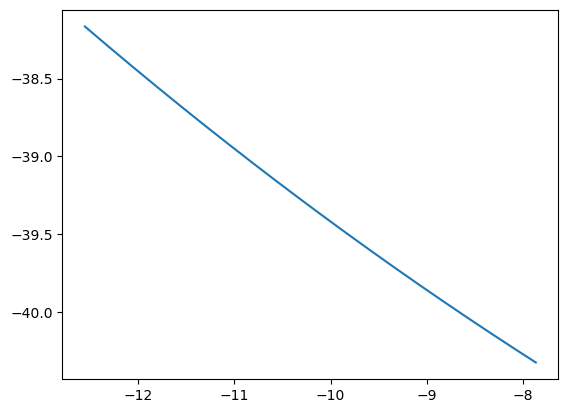

In [12]:
plt.plot(positions[:,100,0], positions[:,100,1])

In [13]:


location = EarthLocation.of_site('LSST')
apt = Time(times+ephem.jd_ref, format="jd")

sc = SkyCoord(x=positions[:,100,0]*u.au, y=positions[:,100,1]*u.au, z=positions[:,100,2]*u.au, 
              representation_type='cartesian', obstime=apt,
              frame=ICRS, location=location)



In [14]:
ack = sc.transform_to(ICRS)

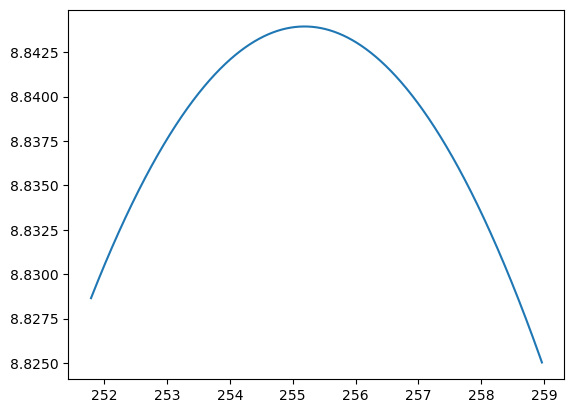

In [15]:
plt.plot(ack.ra, ack.dec)

In [16]:
ack = sc.transform_to(GCRS)

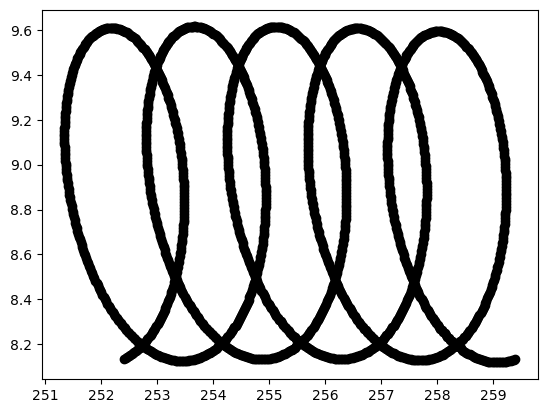

In [17]:
# Ah, there we go, need to go to GCRS
plt.plot(ack.ra, ack.dec, 'ko')

In [18]:
# Looks like this is from the center of the earth. Which is probably close enough. 
ack

<SkyCoord (GCRS: obstime=[2451545.         2451546.00054825 2451547.00109649 ... 2453367.99890351
 2453368.99945175 2453370.        ], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    [(252.41624703, 8.13578843, 41.37906925),
     (252.44185938, 8.13917081, 41.37176852),
     (252.46728655, 8.14276554, 41.36424941), ...,
     (259.34082664, 8.12820033, 42.36530358),
     (259.36736342, 8.13035956, 42.36073267),
     (259.39378169, 8.13272915, 42.35592534)]>